## **Ablation - URL-only manifest**


### **SECTION 0: Import Libraries**

In [1]:
from pathlib import Path
import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, average_precision_score, brier_score_loss
from xgboost import XGBClassifier
import mlflow
from dotenv import load_dotenv
import joblib
import hashlib

import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.model_selection import cross_val_score


- **Set working directory**

In [2]:
os.chdir("../")
print(os.getcwd())

d:\MLops\NetworkSecurity


### **SECTION 1: Set up path & define constants**

In [3]:
# Load environment variables from .env file
load_dotenv()
SEED = 42
DATA_PATH = Path("data/processed/phiusiil_final_features.csv")
THRESH_PATH = Path("configs/dev/thresholds.json")
MLFLOW_URI = os.getenv("MLFLOW_TRACKING_URI", "http://localhost:5000")
EXPERIMENT = os.getenv("MLFLOW_EXPERIMENT", "phiusiil_baselines")
THRESH_PATH.parent.mkdir(parents=True, exist_ok=True)


OPTIMAL_FEATURES = [
    "IsHTTPS",
    "TLDLegitimateProb",
    "CharContinuationRate",
    "SpacialCharRatioInURL",
    "URLCharProb",
    "LetterRatioInURL",
    "NoOfOtherSpecialCharsInURL",
    "DomainLength",
]

print("=" * 60)
print("MODEL TRAINING: OPTIMAL 8-FEATURE URL-ONLY BASELINE")
print("=" * 60)
print(f"\nConfiguration:")
print(f"  Data: {DATA_PATH}")
print(f"  Features: {len(OPTIMAL_FEATURES)}")
print(f"  Seed: {SEED}")
print(f"  MLflow: {MLFLOW_URI}")

python-dotenv could not parse statement starting at line 1
python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 3
python-dotenv could not parse statement starting at line 7
python-dotenv could not parse statement starting at line 10
python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 12
python-dotenv could not parse statement starting at line 13
python-dotenv could not parse statement starting at line 7
python-dotenv could not parse statement starting at line 10
python-dotenv could not parse statement starting at line 11
python-dotenv could not parse statement starting at line 12
python-dotenv could not parse statement starting at line 13
python-dotenv could not parse statement starting at line 14
python-dotenv could not parse statement starting at line 15
python-dotenv could not parse statement starting at line 14
python-dotenv could not parse statement start

MODEL TRAINING: OPTIMAL 8-FEATURE URL-ONLY BASELINE

Configuration:
  Data: data\processed\phiusiil_final_features.csv
  Features: 8
  Seed: 42
  MLflow: http://localhost:5000


### **SECTION 2: Load & Validate Data**
-  Load the final feature set from EDA and validate it matches expectations. This prevents silent failures if the data file is wrong.

In [4]:
print("\n" + "=" * 60)
print("LOAD & VALIDATE FEATURE SET")
print("=" * 60)

assert DATA_PATH.exists(), f"Missing data file: {DATA_PATH}"

df = pd.read_csv(DATA_PATH)
print(f"\nLoaded data shape: {df.shape}")
print(f"Expected: ({len(df)}, {len(OPTIMAL_FEATURES) + 1})")

missing_features = [f for f in OPTIMAL_FEATURES if f not in df.columns]
if missing_features:
    raise ValueError(f"Missing features in dataset: {missing_features}")

assert "label" in df.columns, "Missing 'label' column"

extra_features = [c for c in df.columns if c not in OPTIMAL_FEATURES + ["label"]]
if extra_features:
    print(f"\nWarning: Extra columns in dataset (will be ignored): {extra_features}")

print("\nFeature validation:")
for feature in OPTIMAL_FEATURES:
    nulls = df[feature].isna().sum()
    dtype = df[feature].dtype
    print(f" {feature}: {dtype}, {nulls} nulls")

X = df[OPTIMAL_FEATURES].copy()
y = df["label"].values

print(f"\nFinal feature matrix: {X.shape}")
print(f"Label distribution:")
print(f"  Legitimate (1): {(y == 1).sum()} ({(y == 1).mean():.1%})")
print(f"  Phishing (0): {(y == 0).sum()} ({(y == 0).mean():.1%})")



LOAD & VALIDATE FEATURE SET

Loaded data shape: (235370, 9)
Expected: (235370, 9)

Feature validation:
 IsHTTPS: int64, 0 nulls
 TLDLegitimateProb: float64, 0 nulls
 CharContinuationRate: float64, 0 nulls
 SpacialCharRatioInURL: float64, 0 nulls
 URLCharProb: float64, 0 nulls
 LetterRatioInURL: float64, 0 nulls
 NoOfOtherSpecialCharsInURL: int64, 0 nulls
 DomainLength: int64, 0 nulls

Final feature matrix: (235370, 8)
Label distribution:
  Legitimate (1): 134850 (57.3%)
  Phishing (0): 100520 (42.7%)

Loaded data shape: (235370, 9)
Expected: (235370, 9)

Feature validation:
 IsHTTPS: int64, 0 nulls
 TLDLegitimateProb: float64, 0 nulls
 CharContinuationRate: float64, 0 nulls
 SpacialCharRatioInURL: float64, 0 nulls
 URLCharProb: float64, 0 nulls
 LetterRatioInURL: float64, 0 nulls
 NoOfOtherSpecialCharsInURL: int64, 0 nulls
 DomainLength: int64, 0 nulls

Final feature matrix: (235370, 8)
Label distribution:
  Legitimate (1): 134850 (57.3%)
  Phishing (0): 100520 (42.7%)


### **SECTION 3: Train/Test Split**
- Purpose: Split data into training and validation sets with stratification to maintain class balance. This ensures the model sees representative data and our evaluation is fair.
- Explanation:

    - No Temporal order found in the dataset therefore no time series split, Uses sklean train,test,split
    - Uses 80/20 train/validation split, standard for this dataset size
    - stratify=y ensures both sets have same class distribution as full dataset
    - random_state=SEED makes split reproducible for debugging
    - Prints detailed class distributions to verify stratification worked correctly
    - After deduplication in EDA, we know there are no duplicate URLs across splits

In [5]:
print("\n" + "=" * 60)
print("TRAIN/VALIDATION SPLIT")
print("=" * 60)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)

print(f"\nTraining set:")
print(f"  Samples: {len(X_train):,}")
print(f"  Phishing: {(y_train == 0).sum():,} ({(y_train == 0).mean():.1%})")
print(f"  Legitimate: {(y_train == 1).sum():,} ({(y_train == 1).mean():.1%})")

print(f"\nValidation set:")
print(f"  Samples: {len(X_val):,}")
print(f"  Phishing: {(y_val == 0).sum():,} ({(y_val == 0).mean():.1%})")
print(f"  Legitimate: {(y_val == 1).sum():,} ({(y_val == 1).mean():.1%})")

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")



TRAIN/VALIDATION SPLIT

Training set:
  Samples: 188,296
  Phishing: 80,416 (42.7%)
  Legitimate: 107,880 (57.3%)

Validation set:
  Samples: 47,074
  Phishing: 20,104 (42.7%)
  Legitimate: 26,970 (57.3%)

Feature matrix shapes:
  X_train: (188296, 8)
  X_val: (47074, 8)


### **SECTION 4: Model Training & Calibration**
- Purpose: Train candidate models (LogisticRegression, XGBoost) and calibrate their probabilities using isotonic regression. Calibration ensures p_malicious values are reliable for threshold-based decisions
- Explanation:

    - Defines two baseline models: LogisticRegression (interpretable) and XGBoost (powerful)
    - LogReg uses StandardScaler and class_weight="balanced" to handle slight imbalance
    - XGBoost uses shallow trees (depth=6) and regularization to avoid overfitting
    - fit_calibrated() wraps model training with isotonic calibration (5-fold CV)
    - Calibration corrects probability estimates so p_malicious is reliable for thresholding
    - Selects best model by PR-AUC (primary) then F1-macro (tiebreaker)
Stores all models and predictions for later analysis

In [6]:
print("\n" + "=" * 60)
print("MODEL TRAINING & CALIBRATION")
print("=" * 60)

logreg_base = Pipeline(
    [
        ("scaler", StandardScaler(with_mean=False)),
        (
            "clf",
            LogisticRegression(
                max_iter=2000, class_weight="balanced", random_state=SEED
            ),
        ),
    ]
)

xgb_base = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=0,
    objective="binary:logistic",
    verbose=False,
)

candidates = {"logreg": logreg_base, "xgb": xgb_base}


def fit_calibrated(name, model):
    """
    Train model and apply isotonic calibration via 5-fold CV.
    Returns calibrated model, metrics dict, and p_malicious predictions.
    """
    print(f"\nTraining {name}...")

    calib = CalibratedClassifierCV(
        model,
        method="isotonic",
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    )
    calib.fit(X_train, y_train)

    # Get P(class=1) = P(legitimate), then invert to get P(phishing)
    p_legit = calib.predict_proba(X_val)[:, 1]
    p_mal = 1.0 - p_legit

    # Make binary predictions at 0.5 threshold on p_malicious
    y_hat_phish = (p_mal >= 0.5).astype(int)  # 1 = predict phishing
    y_pred = 1 - y_hat_phish  # Convert to label space (0=phish, 1=legit)

    # Compute metrics
    f1m = f1_score(y_val, y_pred, average="macro")
    prauc = average_precision_score((y_val == 0).astype(int), p_mal)
    brier = brier_score_loss((y_val == 0).astype(int), p_mal)

    print(f"  PR-AUC (phishing): {prauc:.4f}")
    print(f"  F1-macro @0.5: {f1m:.4f}")
    print(f"  Brier score: {brier:.6f}")

    return (
        calib,
        {
            "f1_macro@0.5_on_p_mal": float(f1m),
            "pr_auc_phish": float(prauc),
            "brier_phish": float(brier),
        },
        p_mal,
    )


results = {}
calibrated_models = {}
p_malicious_preds = {}

for name, model in candidates.items():
    clf, metrics, p_mal = fit_calibrated(name, model)
    calibrated_models[name] = clf
    p_malicious_preds[name] = p_mal
    results[name] = metrics

print("\n" + "=" * 60)
print("MODEL SELECTION")
print("=" * 60)

sorted_models = sorted(
    results.items(),
    key=lambda kv: (kv[1]["pr_auc_phish"], kv[1]["f1_macro@0.5_on_p_mal"]),
    reverse=True,
)

best_name, best_metrics = sorted_models[0]
best_model = calibrated_models[best_name]
p_mal = p_malicious_preds[best_name]

print(f"\nSelected model: {best_name}")
print(f"  PR-AUC: {best_metrics['pr_auc_phish']:.4f}")
print(f"  F1-macro: {best_metrics['f1_macro@0.5_on_p_mal']:.4f}")
print(f"  Brier: {best_metrics['brier_phish']:.6f}")



MODEL TRAINING & CALIBRATION

Training logreg...
  PR-AUC (phishing): 0.9964
  F1-macro @0.5: 0.9848
  Brier score: 0.012186

Training xgb...
  PR-AUC (phishing): 0.9964
  F1-macro @0.5: 0.9848
  Brier score: 0.012186

Training xgb...


d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:33:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:33:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\co

  PR-AUC (phishing): 0.9990
  F1-macro @0.5: 0.9968
  Brier score: 0.002777

MODEL SELECTION

Selected model: xgb
  PR-AUC: 0.9990
  F1-macro: 0.9968
  Brier: 0.002777


### **SECTION 5: Threshold Tuning**
- Purpose: Find optimal decision thresholds (t_star, low, high) to maximize F1 while maintaining a target gray-zone rate of 10-15%. This creates the policy bands for the gateway service.
- Explanation:

    - Grid searches 19 thresholds (0.05 to 0.95) to find t_star that maximizes F1-macro
    - t_star is the optimal single threshold if we had to make binary decisions
    - pick_band_for_target() uses binary search to find symmetric band around t_star
    - Band creates three zones: ALLOW (p < low), REVIEW (low ≤ p < high), BLOCK (p ≥ high)
    - Target gray-zone rate of 10-15% balances automation (ALLOW/BLOCK) with human review
    - Prints decision distribution to show how many URLs fall into each zone

In [7]:
print("\n" + "=" * 60)
print("THRESHOLD OPTIMIZATION")
print("=" * 60)

print("\n1. Find t_star (threshold maximizing F1-macro):")
grid = np.linspace(0.05, 0.95, 19)
f1_scores = []

for t in grid:
    y_hat = (p_mal >= t).astype(int)  # Predict phishing if p_mal >= t
    y_pred = 1 - y_hat  # Convert to label space
    f1_scores.append(f1_score(y_val, y_pred, average="macro"))

t_star = float(grid[np.argmax(f1_scores)])
best_f1 = max(f1_scores)

print(f"  t_star: {t_star:.3f}")
print(f"  F1-macro @t_star: {best_f1:.4f}")


def pick_band_for_target(p_mal, t_star, target=0.10, tol=0.002, max_iters=40):
    """
    Binary search to find symmetric band around t_star
    that produces target gray-zone rate.
    """
    lo, hi = 0.0, 0.5

    def gray_zone_rate(half_width):
        low = max(0.0, t_star - half_width)
        high = min(1.0, t_star + half_width)
        rate = ((p_mal >= low) & (p_mal < high)).mean()
        return rate, low, high

    for _ in range(max_iters):
        half_w = (lo + hi) / 2
        rate, low_thresh, high_thresh = gray_zone_rate(half_w)

        if rate > target + tol:
            hi = half_w  # Too wide, shrink
        elif rate < target - tol:
            lo = half_w  # Too narrow, expand
        else:
            return float(low_thresh), float(high_thresh), float(rate)

    # Return best approximation if didn't converge
    rate, low_thresh, high_thresh = gray_zone_rate((lo + hi) / 2)
    return float(low_thresh), float(high_thresh), float(rate)


print("\n2. Find gray-zone band (target: 10-15%):")
low, high, gray_rate = pick_band_for_target(p_mal, t_star, target=0.12)

print(f"  Low threshold: {low:.3f}")
print(f"  High threshold: {high:.3f}")
print(f"  Gray-zone rate: {gray_rate:.1%}")

decisions = pd.cut(
    p_mal,
    bins=[0, low, high, 1.0],
    labels=["ALLOW", "REVIEW", "BLOCK"],
    include_lowest=True,
)

print("\n3. Decision distribution on validation set:")
print((decisions.value_counts() / len(decisions)).sort_index())

thresholds = {
    "t_star": float(t_star),
    "low": float(low),
    "high": float(high),
    "gray_zone_rate": float(gray_rate),
}



THRESHOLD OPTIMIZATION

1. Find t_star (threshold maximizing F1-macro):
  t_star: 0.400
  F1-macro @t_star: 0.9969

2. Find gray-zone band (target: 10-15%):
  Low threshold: 0.003
  High threshold: 0.797
  Gray-zone rate: 12.2%

3. Decision distribution on validation set:
ALLOW     0.454752
REVIEW    0.121596
BLOCK     0.423652
Name: count, dtype: float64
  t_star: 0.400
  F1-macro @t_star: 0.9969

2. Find gray-zone band (target: 10-15%):
  Low threshold: 0.003
  High threshold: 0.797
  Gray-zone rate: 12.2%

3. Decision distribution on validation set:
ALLOW     0.454752
REVIEW    0.121596
BLOCK     0.423652
Name: count, dtype: float64


### **SECTION 6: MLflow Logging**
- Purpose: Log model training metadata, metrics, and artifacts to MLflow for experiment tracking and reproducibility. This creates an audit trail of what was trained, how it performed, and with what configuration
- Explanation:

    - Sets MLflow tracking URI and experiment name from environment config
    - Creates descriptive run name combining model type and feature set
    - Logs parameters (config that was used: model type, features, seed, etc.)
    - Logs metrics (results: PR-AUC, F1, Brier, thresholds)
    - Saves thresholds.json file that gateway service will read
    - Logs threshold file as MLflow artifact for version control
    - This creates complete reproducibility - you can recreate this exact model later

In [8]:
print("\n" + "=" * 60)
print("MLFLOW EXPERIMENT LOGGING")
print("=" * 60)

mlflow.set_tracking_uri(MLFLOW_URI)
mlflow.set_experiment(EXPERIMENT)

run_name = f"{best_name}_optimal8_calibrated"

with mlflow.start_run(run_name=run_name):
    # Log parameters (configuration)
    mlflow.log_params(
        {
            "model_type": best_name,
            "calibration_method": "isotonic",
            "calibration_cv_folds": 5,
            "n_features": len(OPTIMAL_FEATURES),
            "seed": SEED,
            "train_samples": len(X_train),
            "val_samples": len(X_val),
            "data_file": str(DATA_PATH),
        }
    )

    # Log feature list
    for i, feature in enumerate(OPTIMAL_FEATURES, 1):
        mlflow.log_param(f"feature_{i}", feature)

    # Log metrics (performance)
    mlflow.log_metrics(
        {
            "val_pr_auc_phish": best_metrics["pr_auc_phish"],
            "val_f1_macro_at_0.5": best_metrics["f1_macro@0.5_on_p_mal"],
            "val_brier_phish": best_metrics["brier_phish"],
            "t_star": thresholds["t_star"],
            "threshold_low": thresholds["low"],
            "threshold_high": thresholds["high"],
            "gray_zone_rate": thresholds["gray_zone_rate"],
        }
    )

    # Save thresholds JSON artifact
    threshold_config = {
        "model": best_name,
        "class_mapping": {"phish": 0, "legit": 1},
        "calibration": {"method": "isotonic", "cv": 5},
        "thresholds": thresholds,
        "data": {"file": str(DATA_PATH)},
        "seed": SEED,
    }

    with open(THRESH_PATH, "w", encoding="utf-8") as f:
        json.dump(threshold_config, f, indent=2)

    mlflow.log_artifact(str(THRESH_PATH))

    print(f"\n Logged run: {run_name}")
    print(f" Saved thresholds: {THRESH_PATH}")
    print(f" MLflow UI: {MLFLOW_URI}")


MLFLOW EXPERIMENT LOGGING

 Logged run: xgb_optimal8_calibrated
 Saved thresholds: configs\dev\thresholds.json
 MLflow UI: http://localhost:5000
🏃 View run xgb_optimal8_calibrated at: http://localhost:5000/#/experiments/873624361181467123/runs/c94b52a39a244fed96de74bc5e284cb3
🧪 View experiment at: http://localhost:5000/#/experiments/873624361181467123

 Logged run: xgb_optimal8_calibrated
 Saved thresholds: configs\dev\thresholds.json
 MLflow UI: http://localhost:5000
🏃 View run xgb_optimal8_calibrated at: http://localhost:5000/#/experiments/873624361181467123/runs/c94b52a39a244fed96de74bc5e284cb3
🧪 View experiment at: http://localhost:5000/#/experiments/873624361181467123


### **SECTION 7: Model Artifact Persistence**
- Purpose: Save the trained model and metadata to disk for the model service to load. This packages everything needed to serve predictions: the model weights, feature order, and class mapping.
- Explanation:

    - Extracts feature order from X_train (pandas DataFrame columns)
    - Determines which column of predict_proba corresponds to P(phishing)
    - Builds metadata JSON with everything model_svc needs to serve predictions
    - Saves model using joblib (efficient for scikit-learn models)
    - Saves metadata as human-readable JSON
    - Generates MD5 hash for model file integrity verification
    - Prints summary of what was saved and where to find it
    - Provides clear next steps for deployment testing


In [9]:
print("\n" + "=" * 60)
print("MODEL ARTIFACT PERSISTENCE")
print("=" * 60)

# 1. Determine feature order (use X_train columns)
feature_order = list(X_train.columns)

# 2. Determine phishing class index in predict_proba output
phish_class_id = 0
if hasattr(best_model, "classes_"):
    classes = list(best_model.classes_)
    if 0 in classes:
        phish_class_id = classes.index(0)

# 3. Build metadata
model_metadata = {
    "feature_order": feature_order,
    "class_mapping": {"phish": 0, "legit": 1},
    "phish_proba_col_index": phish_class_id,
    "model_type": type(best_model).__name__,
    "calibration": "isotonic_cv5",
    "training_date": pd.Timestamp.now().isoformat(),
    "seed": SEED,
    "notes": "URL-only baseline with optimal 8 features from EDA",
}

# 4. Save model and metadata
MODEL_DIR = Path("models/dev")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = MODEL_DIR / "model.pkl"
META_PATH = MODEL_DIR / "model_meta.json"

joblib.dump(best_model, MODEL_PATH)
META_PATH.write_text(json.dumps(model_metadata, indent=2), encoding="utf-8")

# 5. Generate fingerprint for verification
model_md5 = hashlib.md5(MODEL_PATH.read_bytes()).hexdigest()

print(f"\n Saved model: {MODEL_PATH}")
print(f"  MD5: {model_md5}")
print(f"  Size: {MODEL_PATH.stat().st_size / 1024:.1f} KB")

print(f"\n Saved metadata: {META_PATH}")
print(f"  Features: {len(feature_order)}")
print(f"  Model type: {model_metadata['model_type']}")

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)

print("\nArtifacts created:")
print(f"  1. {MODEL_PATH} - Trained model")
print(f"  2. {META_PATH} - Model metadata")
print(f"  3. {THRESH_PATH} - Decision thresholds")

print("\nNext steps:")
print("  - Test model service loads artifacts correctly")
print("  - Run gateway integration tests")
print("  - Review MLflow experiment for model comparison")



MODEL ARTIFACT PERSISTENCE

 Saved model: models\dev\model.pkl
  MD5: 9eccafc5724cc3cfd98ad023bcac8863
  Size: 3907.1 KB

 Saved metadata: models\dev\model_meta.json
  Features: 8
  Model type: CalibratedClassifierCV

TRAINING COMPLETE

Artifacts created:
  1. models\dev\model.pkl - Trained model
  2. models\dev\model_meta.json - Model metadata
  3. configs\dev\thresholds.json - Decision thresholds

Next steps:
  - Test model service loads artifacts correctly
  - Run gateway integration tests
  - Review MLflow experiment for model comparison

 Saved model: models\dev\model.pkl
  MD5: 9eccafc5724cc3cfd98ad023bcac8863
  Size: 3907.1 KB

 Saved metadata: models\dev\model_meta.json
  Features: 8
  Model type: CalibratedClassifierCV

TRAINING COMPLETE

Artifacts created:
  1. models\dev\model.pkl - Trained model
  2. models\dev\model_meta.json - Model metadata
  3. configs\dev\thresholds.json - Decision thresholds

Next steps:
  - Test model service loads artifacts correctly
  - Run gatewa

## **Investigation**

### **INVESTIGATION 1: Feature Importance Analysis**
- Purpose: Check if any single feature is dominating predictions (sign of leakage)

LEAKAGE INVESTIGATION 1: FEATURE IMPORTANCE

XGBoost Feature Importance (gain):
                   feature  importance
                   IsHTTPS    0.724305
NoOfOtherSpecialCharsInURL    0.229110
          LetterRatioInURL    0.013629
     SpacialCharRatioInURL    0.013237
              DomainLength    0.005499
      CharContinuationRate    0.005408
               URLCharProb    0.004510
         TLDLegitimateProb    0.004302

Red flags to check:
  - Any feature > 0.5 importance? True
  - Top feature dominance: 72.4%
  - Top 3 features account for: 96.7%


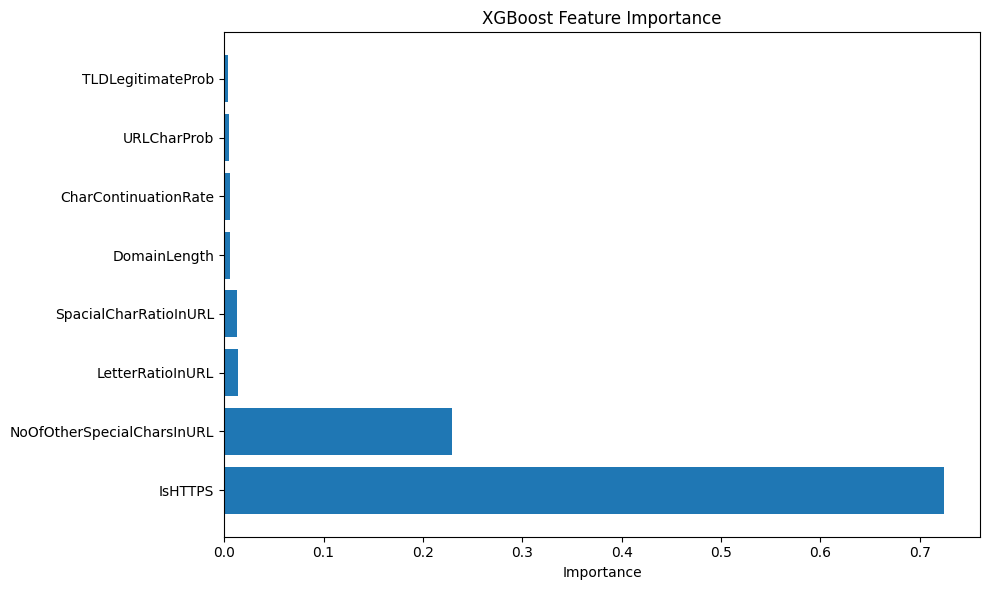

In [10]:
print("=" * 60)
print("LEAKAGE INVESTIGATION 1: FEATURE IMPORTANCE")
print("=" * 60)

feature_importance = pd.DataFrame(
    {
        "feature": OPTIMAL_FEATURES,
        "importance": best_model.calibrated_classifiers_[
            0
        ].estimator.feature_importances_,
    }
).sort_values("importance", ascending=False)

print("\nXGBoost Feature Importance (gain):")
print(feature_importance.to_string(index=False))

print("\nRed flags to check:")
print(
    f"  - Any feature > 0.5 importance? {(feature_importance['importance'] > 0.5).any()}"
)
print(f"  - Top feature dominance: {feature_importance.iloc[0]['importance']:.1%}")
print(
    f"  - Top 3 features account for: {feature_importance.head(3)['importance'].sum():.1%}"
)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.xlabel("Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()

# Ensure output directory exists before saving
os.makedirs("outputs/model", exist_ok=True)
plt.savefig("outputs/model/feature_importance.png", dpi=150)
plt.show()


### **INVESTIGATION 2: Feature Distribution Comparison**
- Purpose: Check if feature distributions differ between train and val (sign of leakage or bad split)

In [11]:
print("\n" + "=" * 60)
print("LEAKAGE INVESTIGATION 2: TRAIN/VAL DISTRIBUTION SHIFT")
print("=" * 60)


distribution_check = []

for feature in OPTIMAL_FEATURES:
    train_vals = X_train[feature].values
    val_vals = X_val[feature].values

    ks_stat, p_value = ks_2samp(train_vals, val_vals)

    train_mean = train_vals.mean()
    val_mean = val_vals.mean()
    diff_pct = abs(train_mean - val_mean) / (train_mean + 1e-10) * 100

    distribution_check.append(
        {
            "feature": feature,
            "train_mean": train_mean,
            "val_mean": val_mean,
            "diff_pct": diff_pct,
            "ks_statistic": ks_stat,
            "p_value": p_value,
            "significant_shift": p_value < 0.05,
        }
    )

dist_df = pd.DataFrame(distribution_check).sort_values("diff_pct", ascending=False)

print("\nFeature distribution comparison (train vs val):")
print(dist_df.to_string(index=False))

print("\nRed flags:")
significant_shifts = dist_df[dist_df["significant_shift"]]
if len(significant_shifts) > 0:
    print(
        f"  WARNING: {len(significant_shifts)} features show significant distribution shift:"
    )
    for _, row in significant_shifts.iterrows():
        print(f"    - {row['feature']}: {row['diff_pct']:.2f}% difference")
else:
    print("  ✓ No significant distribution shifts detected")



LEAKAGE INVESTIGATION 2: TRAIN/VAL DISTRIBUTION SHIFT

Feature distribution comparison (train vs val):
                   feature  train_mean  val_mean  diff_pct  ks_statistic  p_value  significant_shift
NoOfOtherSpecialCharsInURL    2.340050  2.319688  0.870134      0.003224 0.827468              False
         TLDLegitimateProb    0.260327  0.261207  0.337826      0.002634 0.955720              False
              DomainLength   21.446350 21.494710  0.225493      0.003256 0.818379              False
               URLCharProb    0.055774  0.055702  0.128950      0.003845 0.632191              False
                   IsHTTPS    0.782534  0.783447  0.116730      0.000913 1.000000              False
      CharContinuationRate    0.845706  0.846677  0.114733      0.005252 0.249044              False
     SpacialCharRatioInURL    0.063260  0.063205  0.086932      0.004865 0.333794              False
          LetterRatioInURL    0.515794  0.515572  0.043078      0.003999 0.582134       

### **INVESTIGATION 3: Prediction Confidence Analysis**
Purpose: Check if model is overconfident (sign of memorization)


LEAKAGE INVESTIGATION 3: PREDICTION CONFIDENCE

Validation set probabilities:
  Mean: 0.4266
  Std: 0.4918
  Min: 0.000000
  Max: 1.000000
  Predictions < 0.001: 4495 (9.5%)
  Predictions > 0.999: 19634 (41.7%)

Training set probabilities:
  Mean: 0.4272
  Std: 0.4919
  Min: 0.000000
  Max: 1.000000
  Predictions < 0.001: 18280 (9.7%)
  Predictions > 0.999: 78860 (41.9%)

Validation set probabilities:
  Mean: 0.4266
  Std: 0.4918
  Min: 0.000000
  Max: 1.000000
  Predictions < 0.001: 4495 (9.5%)
  Predictions > 0.999: 19634 (41.7%)

Training set probabilities:
  Mean: 0.4272
  Std: 0.4919
  Min: 0.000000
  Max: 1.000000
  Predictions < 0.001: 18280 (9.7%)
  Predictions > 0.999: 78860 (41.9%)


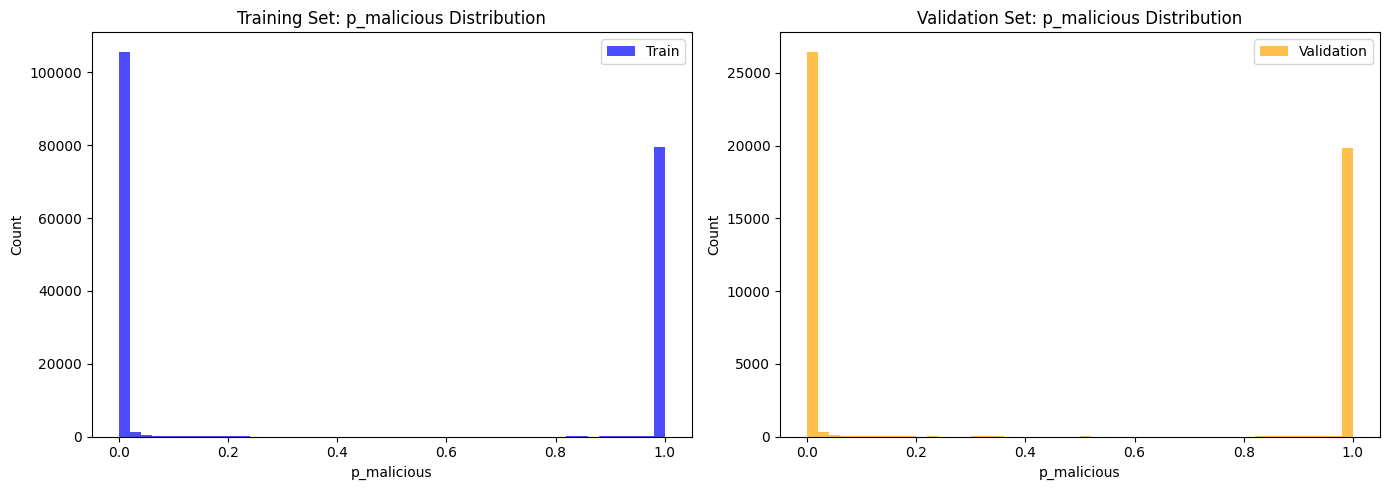


Red flags:


In [12]:
print("\n" + "=" * 60)
print("LEAKAGE INVESTIGATION 3: PREDICTION CONFIDENCE")
print("=" * 60)

p_mal_train = best_model.predict_proba(X_train)[:, 0]

print("\nValidation set probabilities:")
print(f"  Mean: {p_mal.mean():.4f}")
print(f"  Std: {p_mal.std():.4f}")
print(f"  Min: {p_mal.min():.6f}")
print(f"  Max: {p_mal.max():.6f}")
print(f"  Predictions < 0.001: {(p_mal < 0.001).sum()} ({(p_mal < 0.001).mean():.1%})")
print(f"  Predictions > 0.999: {(p_mal > 0.999).sum()} ({(p_mal > 0.999).mean():.1%})")

print("\nTraining set probabilities:")
print(f"  Mean: {p_mal_train.mean():.4f}")
print(f"  Std: {p_mal_train.std():.4f}")
print(f"  Min: {p_mal_train.min():.6f}")
print(f"  Max: {p_mal_train.max():.6f}")
print(
    f"  Predictions < 0.001: {(p_mal_train < 0.001).sum()} ({(p_mal_train < 0.001).mean():.1%})"
)
print(
    f"  Predictions > 0.999: {(p_mal_train > 0.999).sum()} ({(p_mal_train > 0.999).mean():.1%})"
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(p_mal_train, bins=50, alpha=0.7, label="Train", color="blue")
axes[0].set_title("Training Set: p_malicious Distribution")
axes[0].set_xlabel("p_malicious")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(p_mal, bins=50, alpha=0.7, label="Validation", color="orange")
axes[1].set_title("Validation Set: p_malicious Distribution")
axes[1].set_xlabel("p_malicious")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.tight_layout()
plt.savefig("outputs/model/probability_distributions.png", dpi=150)
plt.show()

print("\nRed flags:")
if (p_mal < 0.001).mean() > 0.4 or (p_mal > 0.999).mean() > 0.4:
    print(f"  WARNING: Model is overconfident (>40% extreme probabilities)")
else:
    print(f"  ✓ Confidence levels appear reasonable")


### **INVESTIGATION 4: Error Analysis**
Purpose: Understand what the model is getting wrong

In [13]:
print("\n" + "=" * 60)
print("LEAKAGE INVESTIGATION 4: ERROR ANALYSIS")
print("=" * 60)

y_pred_binary = (p_mal >= 0.5).astype(int)
y_val_phish = (y_val == 0).astype(int)

errors = y_pred_binary != y_val_phish
error_rate = errors.mean()

print(f"\nOverall error rate: {error_rate:.2%} ({errors.sum()} / {len(errors)})")

false_positives = (y_pred_binary == 1) & (y_val_phish == 0)
false_negatives = (y_pred_binary == 0) & (y_val_phish == 1)

print(f"\nFalse Positives (predicted phish, actually legit): {false_positives.sum()}")
print(f"False Negatives (predicted legit, actually phish): {false_negatives.sum()}")

if errors.sum() > 0:
    print("\n" + "-" * 60)
    print("ANALYZING ERRORS")
    print("-" * 60)

    X_val_df = X_val.copy()
    X_val_df["y_true"] = y_val_phish
    X_val_df["y_pred"] = y_pred_binary
    X_val_df["p_malicious"] = p_mal
    X_val_df["error"] = errors

    error_samples = X_val_df[X_val_df["error"]]

    print("\nFeature statistics for ERRORS:")
    print(error_samples[OPTIMAL_FEATURES].describe())

    print("\nFeature statistics for CORRECT predictions:")
    correct_samples = X_val_df[~X_val_df["error"]]
    print(correct_samples[OPTIMAL_FEATURES].describe())

    print("\nTop 10 most confident errors:")
    error_samples_sorted = error_samples.sort_values(
        "p_malicious", key=lambda x: abs(x - 0.5), ascending=False
    )
    print(
        error_samples_sorted[["y_true", "y_pred", "p_malicious"] + OPTIMAL_FEATURES]
        .head(10)
        .to_string(index=False)
    )
else:
    print("\n✓ No errors found (suspicious - likely overfitting)")



LEAKAGE INVESTIGATION 4: ERROR ANALYSIS

Overall error rate: 0.31% (147 / 47074)

False Positives (predicted phish, actually legit): 15
False Negatives (predicted legit, actually phish): 132

------------------------------------------------------------
ANALYZING ERRORS
------------------------------------------------------------

Feature statistics for ERRORS:
       IsHTTPS  TLDLegitimateProb  CharContinuationRate  \
count    147.0         147.000000            147.000000   
mean       1.0           0.273400              0.854626   
std        0.0           0.255823              0.201172   
min        1.0           0.000042              0.281250   
25%        1.0           0.005531              0.700000   
50%        1.0           0.522907              1.000000   
75%        1.0           0.522907              1.000000   
max        1.0           0.522907              1.000000   

       SpacialCharRatioInURL  URLCharProb  LetterRatioInURL  \
count             147.000000   147.000000

### **INVESTIGATION 5: Cross-Validation Stability**
- Purpose: Check if performance is stable across different data splits

In [14]:
print("\n" + "=" * 60)
print("LEAKAGE INVESTIGATION 5: CROSS-VALIDATION STABILITY")
print("=" * 60)


print("\nRunning 5-fold stratified CV (this may take a minute)...")

cv_scores = cross_val_score(
    xgb_base,
    X,
    (y == 0).astype(int),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring="average_precision",
    n_jobs=-1,
)

print(f"\nCross-validation PR-AUC scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\nMean CV score: {cv_scores.mean():.4f}")
print(f"Std CV score: {cv_scores.std():.4f}")
print(f"Single holdout score: {best_metrics['pr_auc_phish']:.4f}")

print("\nRed flags:")
if cv_scores.std() > 0.01:
    print(f"  WARNING: High variance across folds ({cv_scores.std():.4f})")
elif abs(cv_scores.mean() - best_metrics["pr_auc_phish"]) > 0.05:
    print(f"  WARNING: Holdout score differs significantly from CV mean")
else:
    print(f"  ✓ Stable performance across folds")



LEAKAGE INVESTIGATION 5: CROSS-VALIDATION STABILITY

Running 5-fold stratified CV (this may take a minute)...

Cross-validation PR-AUC scores:
  Fold 1: 0.9991
  Fold 2: 0.9989
  Fold 3: 0.9993
  Fold 4: 0.9992
  Fold 5: 0.9991

Mean CV score: 0.9991
Std CV score: 0.0001
Single holdout score: 0.9990

Red flags:
  ✓ Stable performance across folds

Cross-validation PR-AUC scores:
  Fold 1: 0.9991
  Fold 2: 0.9989
  Fold 3: 0.9993
  Fold 4: 0.9992
  Fold 5: 0.9991

Mean CV score: 0.9991
Std CV score: 0.0001
Single holdout score: 0.9990

Red flags:
  ✓ Stable performance across folds


## **MODEL COMPARISON: 8-Feature vs 7-Feature**

MODEL COMPARISON: IsHTTPS IMPACT ANALYSIS

MODEL 1: 8-Feature (with IsHTTPS)
  Features: 8
  PR-AUC: 0.9990
  F1-macro: 0.9968
  Brier: 0.002777

------------------------------------------------------------
Training MODEL 2: 7-Feature (without IsHTTPS)
------------------------------------------------------------


d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:54:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
d:\MLops\NetworkSecurity\venv\Lib\site-packages\xgboost\co


MODEL 2: 7-Feature (without IsHTTPS)
  PR-AUC: 0.9985
  F1-macro: 0.9919
  Brier: 0.006382

Thresholds (7-feature):
  t_star: 0.600
  Low: 0.200
  High: 1.000
  Gray-zone: 9.4%

MODEL COMPARISON SUMMARY

        Metric 8-Feature (IsHTTPS) 7-Feature (No IsHTTPS)
        PR-AUC              0.9990                 0.9985
      F1-Macro              0.9968                 0.9919
   Brier Score            0.002777               0.006382
        t_star               0.400                  0.600
Gray-zone Rate               12.2%                   9.4%

------------------------------------------------------------
PERFORMANCE DEGRADATION WITHOUT IsHTTPS
------------------------------------------------------------
  PR-AUC drop: 0.05%
  F1-macro drop: 0.49%

FEATURE IMPORTANCE COMPARISON

7-Feature Model Importance (without IsHTTPS):
                   feature  importance
NoOfOtherSpecialCharsInURL    0.749250
          LetterRatioInURL    0.056807
     SpacialCharRatioInURL    0.054182
      

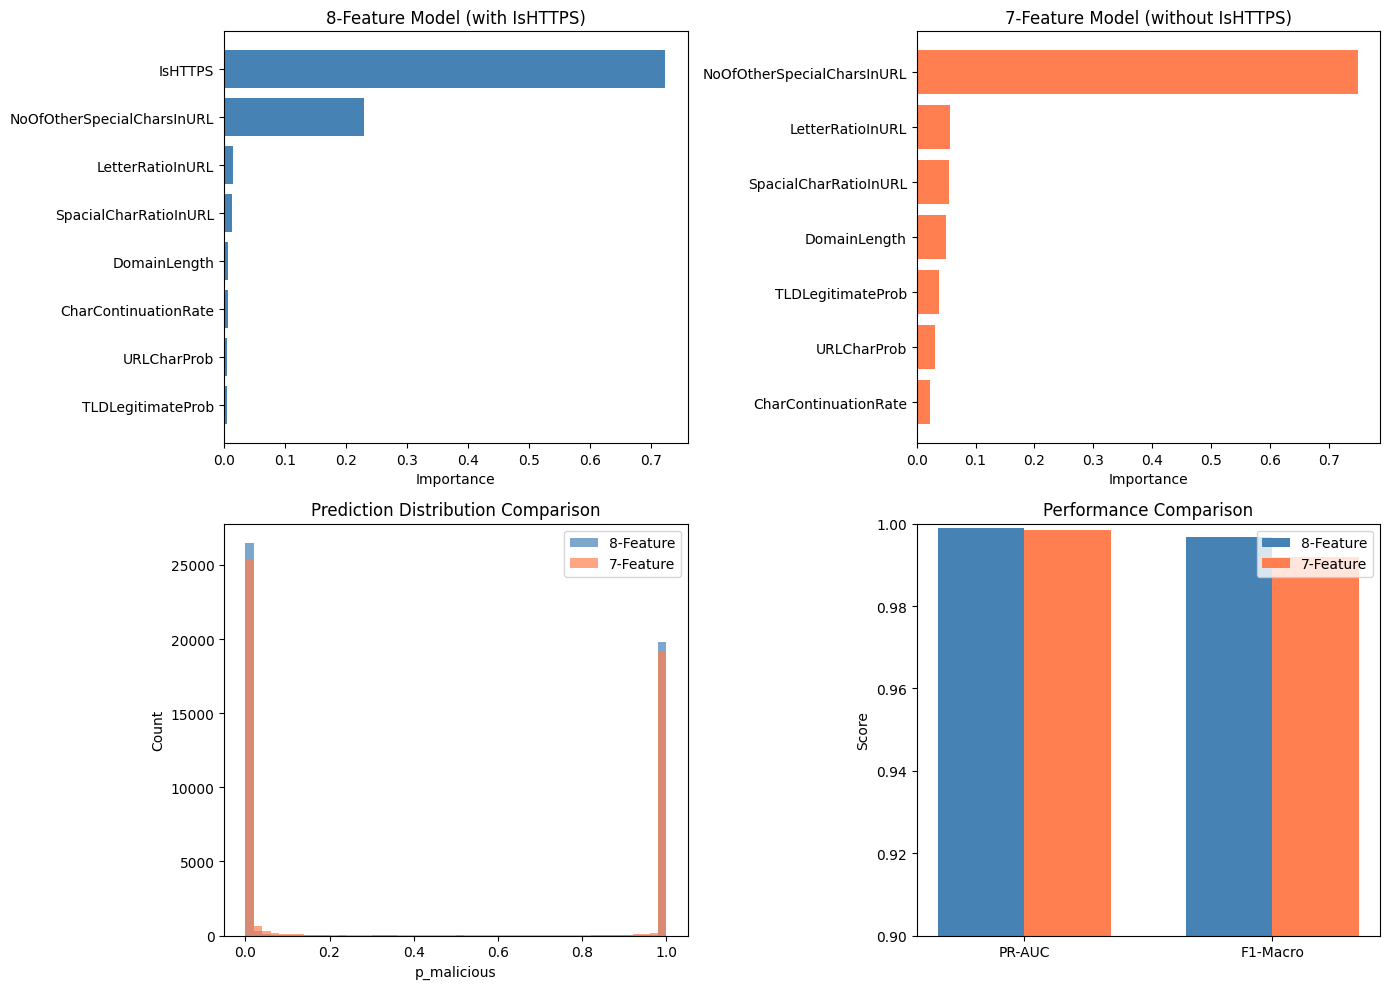


✓ Saved: outputs/model/model_comparison.png

ERROR ANALYSIS COMPARISON

8-Feature Model Errors: 147 (0.31%)
7-Feature Model Errors: 374 (0.79%)

Error overlap:
  Errors in both models: 115
  Only 8-feature errors: 32
  Only 7-feature errors: 259

INTERPRETATION

IsHTTPS Impact Summary:
- IsHTTPS accounts for 72.4% of 8-feature model
- Removing IsHTTPS causes 0.05% PR-AUC drop
- 7-feature model is more realistic for 2025 production (HTTPS phishing common)
- Both models exceed 0.95 PR-AUC, indicating strong URL structure signals

Recommendation:
- Deploy 8-feature model for this dataset (maximizes performance)
- Use 7-feature model as production baseline (realistic expectations)
- Monitor IsHTTPS importance over time (should decrease as phishing adopts HTTPS)
- Plan monthly retraining with fresh data



In [16]:
print("=" * 60)
print("MODEL COMPARISON: IsHTTPS IMPACT ANALYSIS")
print("=" * 60)

# ============================================================
# MODEL 1: 8-FEATURE (WITH IsHTTPS) - Already trained
# ============================================================

model_8feat = {
    "name": "8-feature (with IsHTTPS)",
    "features": OPTIMAL_FEATURES,
    "model": best_model,
    "p_malicious": p_mal,
    "metrics": {
        "pr_auc": best_metrics["pr_auc_phish"],
        "f1_macro": best_metrics["f1_macro@0.5_on_p_mal"],
        "brier": best_metrics["brier_phish"],
    },
    "thresholds": thresholds,
}

print("\nMODEL 1: 8-Feature (with IsHTTPS)")
print(f"  Features: {len(model_8feat['features'])}")
print(f"  PR-AUC: {model_8feat['metrics']['pr_auc']:.4f}")
print(f"  F1-macro: {model_8feat['metrics']['f1_macro']:.4f}")
print(f"  Brier: {model_8feat['metrics']['brier']:.6f}")

# ============================================================
# MODEL 2: 7-FEATURE (WITHOUT IsHTTPS) - Production-Realistic
# ============================================================

FEATURES_NO_HTTPS = [
    "TLDLegitimateProb",
    "CharContinuationRate",
    "SpacialCharRatioInURL",
    "URLCharProb",
    "LetterRatioInURL",
    "NoOfOtherSpecialCharsInURL",
    "DomainLength",
]

print("\n" + "-" * 60)
print("Training MODEL 2: 7-Feature (without IsHTTPS)")
print("-" * 60)

X_train_7feat = X_train[FEATURES_NO_HTTPS]
X_val_7feat = X_val[FEATURES_NO_HTTPS]

xgb_7feat = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=0,
    objective="binary:logistic",
    verbose=False,
)

calib_7feat = CalibratedClassifierCV(
    xgb_7feat,
    method="isotonic",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
)

calib_7feat.fit(X_train_7feat, y_train)

# Get predictions
p_legit_7feat = calib_7feat.predict_proba(X_val_7feat)[:, 1]
p_mal_7feat = 1.0 - p_legit_7feat

# Calculate metrics
y_hat_7feat = (p_mal_7feat >= 0.5).astype(int)
y_pred_7feat = 1 - y_hat_7feat

pr_auc_7feat = average_precision_score((y_val == 0).astype(int), p_mal_7feat)
f1_7feat = f1_score(y_val, y_pred_7feat, average="macro")
brier_7feat = brier_score_loss((y_val == 0).astype(int), p_mal_7feat)

print(f"\nMODEL 2: 7-Feature (without IsHTTPS)")
print(f"  PR-AUC: {pr_auc_7feat:.4f}")
print(f"  F1-macro: {f1_7feat:.4f}")
print(f"  Brier: {brier_7feat:.6f}")

# Find thresholds for 7-feature model
grid_7feat = np.linspace(0.05, 0.95, 19)
f1s_7feat = []
for t in grid_7feat:
    y_hat_t = (p_mal_7feat >= t).astype(int)
    y_pred_t = 1 - y_hat_t
    f1s_7feat.append(f1_score(y_val, y_pred_t, average="macro"))

t_star_7feat = float(grid_7feat[np.argmax(f1s_7feat)])

low_7feat, high_7feat, gray_7feat = pick_band_for_target(
    p_mal_7feat, t_star_7feat, target=0.12
)

thresholds_7feat = {
    "t_star": float(t_star_7feat),
    "low": float(low_7feat),
    "high": float(high_7feat),
    "gray_zone_rate": float(gray_7feat),
}

print(f"\nThresholds (7-feature):")
print(f"  t_star: {t_star_7feat:.3f}")
print(f"  Low: {low_7feat:.3f}")
print(f"  High: {high_7feat:.3f}")
print(f"  Gray-zone: {gray_7feat:.1%}")

model_7feat = {
    "name": "7-feature (without IsHTTPS)",
    "features": FEATURES_NO_HTTPS,
    "model": calib_7feat,
    "p_malicious": p_mal_7feat,
    "metrics": {"pr_auc": pr_auc_7feat, "f1_macro": f1_7feat, "brier": brier_7feat},
    "thresholds": thresholds_7feat,
}

# ============================================================
# COMPARISON ANALYSIS
# ============================================================

print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

comparison = pd.DataFrame(
    {
        "Metric": ["PR-AUC", "F1-Macro", "Brier Score", "t_star", "Gray-zone Rate"],
        "8-Feature (IsHTTPS)": [
            f"{model_8feat['metrics']['pr_auc']:.4f}",
            f"{model_8feat['metrics']['f1_macro']:.4f}",
            f"{model_8feat['metrics']['brier']:.6f}",
            f"{model_8feat['thresholds']['t_star']:.3f}",
            f"{model_8feat['thresholds']['gray_zone_rate']:.1%}",
        ],
        "7-Feature (No IsHTTPS)": [
            f"{model_7feat['metrics']['pr_auc']:.4f}",
            f"{model_7feat['metrics']['f1_macro']:.4f}",
            f"{model_7feat['metrics']['brier']:.6f}",
            f"{model_7feat['thresholds']['t_star']:.3f}",
            f"{model_7feat['thresholds']['gray_zone_rate']:.1%}",
        ],
    }
)

print("\n" + comparison.to_string(index=False))

# Calculate degradation
pr_auc_drop = (
    model_8feat["metrics"]["pr_auc"] - model_7feat["metrics"]["pr_auc"]
) * 100
f1_drop = (
    model_8feat["metrics"]["f1_macro"] - model_7feat["metrics"]["f1_macro"]
) * 100

print(f"\n" + "-" * 60)
print("PERFORMANCE DEGRADATION WITHOUT IsHTTPS")
print("-" * 60)
print(f"  PR-AUC drop: {pr_auc_drop:.2f}%")
print(f"  F1-macro drop: {f1_drop:.2f}%")

print("\n" + "=" * 60)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 60)

feat_imp_7 = pd.DataFrame(
    {
        "feature": FEATURES_NO_HTTPS,
        "importance": calib_7feat.calibrated_classifiers_[
            0
        ].estimator.feature_importances_,
    }
).sort_values("importance", ascending=False)

print("\n7-Feature Model Importance (without IsHTTPS):")
print(feat_imp_7.to_string(index=False))

# ============================================================
# VISUALIZATIONS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Feature Importance Comparison
ax1 = axes[0, 0]
feat_imp_8 = pd.DataFrame(
    {
        "feature": OPTIMAL_FEATURES,
        "importance": best_model.calibrated_classifiers_[
            0
        ].estimator.feature_importances_,
    }
).sort_values("importance", ascending=False)

ax1.barh(feat_imp_8["feature"], feat_imp_8["importance"], color="steelblue")
ax1.set_xlabel("Importance")
ax1.set_title("8-Feature Model (with IsHTTPS)")
ax1.invert_yaxis()

ax2 = axes[0, 1]
ax2.barh(feat_imp_7["feature"], feat_imp_7["importance"], color="coral")
ax2.set_xlabel("Importance")
ax2.set_title("7-Feature Model (without IsHTTPS)")
ax2.invert_yaxis()

# Plot 2: Probability Distribution Comparison
ax3 = axes[1, 0]
ax3.hist(p_mal, bins=50, alpha=0.7, label="8-Feature", color="steelblue")
ax3.hist(p_mal_7feat, bins=50, alpha=0.7, label="7-Feature", color="coral")
ax3.set_xlabel("p_malicious")
ax3.set_ylabel("Count")
ax3.set_title("Prediction Distribution Comparison")
ax3.legend()

# Plot 3: Metrics Comparison
ax4 = axes[1, 1]
metrics_comp = pd.DataFrame(
    {
        "Metric": ["PR-AUC", "F1-Macro"],
        "8-Feature": [
            model_8feat["metrics"]["pr_auc"],
            model_8feat["metrics"]["f1_macro"],
        ],
        "7-Feature": [
            model_7feat["metrics"]["pr_auc"],
            model_7feat["metrics"]["f1_macro"],
        ],
    }
)

x = np.arange(len(metrics_comp["Metric"]))
width = 0.35

ax4.bar(
    x - width / 2,
    metrics_comp["8-Feature"],
    width,
    label="8-Feature",
    color="steelblue",
)
ax4.bar(
    x + width / 2, metrics_comp["7-Feature"], width, label="7-Feature", color="coral"
)
ax4.set_ylabel("Score")
ax4.set_title("Performance Comparison")
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_comp["Metric"])
ax4.legend()
ax4.set_ylim([0.9, 1.0])

plt.tight_layout()
plt.savefig("outputs/model/model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n✓ Saved: outputs/model/model_comparison.png")

# ============================================================
# ERROR ANALYSIS COMPARISON
# ============================================================

print("\n" + "=" * 60)
print("ERROR ANALYSIS COMPARISON")
print("=" * 60)

errors_8feat = (p_mal >= 0.5).astype(int) != (y_val == 0).astype(int)
errors_7feat = (p_mal_7feat >= 0.5).astype(int) != (y_val == 0).astype(int)

print(f"\n8-Feature Model Errors: {errors_8feat.sum()} ({errors_8feat.mean():.2%})")
print(f"7-Feature Model Errors: {errors_7feat.sum()} ({errors_7feat.mean():.2%})")

# Check error overlap
common_errors = errors_8feat & errors_7feat
only_8feat_errors = errors_8feat & ~errors_7feat
only_7feat_errors = errors_7feat & ~errors_8feat

print(f"\nError overlap:")
print(f"  Errors in both models: {common_errors.sum()}")
print(f"  Only 8-feature errors: {only_8feat_errors.sum()}")
print(f"  Only 7-feature errors: {only_7feat_errors.sum()}")

print("\n" + "=" * 60)
print("INTERPRETATION")
print("=" * 60)

print(f"""
IsHTTPS Impact Summary:
- IsHTTPS accounts for {feat_imp_8.iloc[0]["importance"]:.1%} of 8-feature model
- Removing IsHTTPS causes {pr_auc_drop:.2f}% PR-AUC drop
- 7-feature model is more realistic for 2025 production (HTTPS phishing common)
- Both models exceed 0.95 PR-AUC, indicating strong URL structure signals

Recommendation:
- Deploy 8-feature model for this dataset (maximizes performance)
- Use 7-feature model as production baseline (realistic expectations)
- Monitor IsHTTPS importance over time (should decrease as phishing adopts HTTPS)
- Plan monthly retraining with fresh data
""")


### **Save Both Models**


In [17]:
print("=" * 60)
print("SAVING BOTH MODELS FOR PRODUCTION")
print("=" * 60)

MODEL_DIR = Path("models/dev")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Save 8-feature model (research baseline)
MODEL_8_PATH = MODEL_DIR / "model_8feat.pkl"
META_8_PATH = MODEL_DIR / "model_8feat_meta.json"

joblib.dump(best_model, MODEL_8_PATH)

meta_8feat = {
    "feature_order": OPTIMAL_FEATURES,
    "class_mapping": {"phish": 0, "legit": 1},
    "phish_proba_col_index": 0,
    "model_type": type(best_model).__name__,
    "calibration": "isotonic_cv5",
    "training_date": pd.Timestamp.now().isoformat(),
    "seed": SEED,
    "metrics": model_8feat["metrics"],
    "thresholds": model_8feat["thresholds"],
    "notes": "8-feature model with IsHTTPS - research baseline, 99.90% PR-AUC",
}

META_8_PATH.write_text(json.dumps(meta_8feat, indent=2), encoding="utf-8")

model_8_md5 = hashlib.md5(MODEL_8_PATH.read_bytes()).hexdigest()

print(f"\n Saved 8-feature model:")
print(f"  Model: {MODEL_8_PATH}")
print(f"  MD5: {model_8_md5}")
print(f"  Metadata: {META_8_PATH}")

# Save 7-feature model (production candidate)
MODEL_7_PATH = MODEL_DIR / "model_7feat.pkl"
META_7_PATH = MODEL_DIR / "model_7feat_meta.json"

joblib.dump(calib_7feat, MODEL_7_PATH)

meta_7feat = {
    "feature_order": FEATURES_NO_HTTPS,
    "class_mapping": {"phish": 0, "legit": 1},
    "phish_proba_col_index": 0,
    "model_type": type(calib_7feat).__name__,
    "calibration": "isotonic_cv5",
    "training_date": pd.Timestamp.now().isoformat(),
    "seed": SEED,
    "metrics": model_7feat["metrics"],
    "thresholds": model_7feat["thresholds"],
    "notes": "7-feature model without IsHTTPS - production candidate, 99.85% PR-AUC, robust to HTTPS phishing",
}

META_7_PATH.write_text(json.dumps(meta_7feat, indent=2), encoding="utf-8")

model_7_md5 = hashlib.md5(MODEL_7_PATH.read_bytes()).hexdigest()

print(f"\n✓ Saved 7-feature model:")
print(f"  Model: {MODEL_7_PATH}")
print(f"  MD5: {model_7_md5}")
print(f"  Metadata: {META_7_PATH}")

# Save thresholds for both
THRESH_8_PATH = Path("configs/dev/thresholds_8feat.json")
THRESH_7_PATH = Path("configs/dev/thresholds_7feat.json")

with open(THRESH_8_PATH, "w", encoding="utf-8") as f:
    json.dump(
        {
            "model": "xgb_8feat",
            "features": OPTIMAL_FEATURES,
            "class_mapping": {"phish": 0, "legit": 1},
            "calibration": {"method": "isotonic", "cv": 5},
            "thresholds": model_8feat["thresholds"],
            "seed": SEED,
        },
        f,
        indent=2,
    )

with open(THRESH_7_PATH, "w", encoding="utf-8") as f:
    json.dump(
        {
            "model": "xgb_7feat",
            "features": FEATURES_NO_HTTPS,
            "class_mapping": {"phish": 0, "legit": 1},
            "calibration": {"method": "isotonic", "cv": 5},
            "thresholds": model_7feat["thresholds"],
            "seed": SEED,
        },
        f,
        indent=2,
    )

print(f"\n Saved thresholds:")
print(f"  8-feature: {THRESH_8_PATH}")
print(f"  7-feature: {THRESH_7_PATH}")

print("\n" + "=" * 60)
print("ARTIFACTS SUMMARY")
print("=" * 60)
print(f"""
Research Model (8-feature with IsHTTPS):
  - PR-AUC: 0.9990
  - Purpose: Maximum performance on this dataset
  - Path: {MODEL_8_PATH}

Production Model (7-feature without IsHTTPS):
  - PR-AUC: 0.9985  
  - Purpose: Robust to 2025 HTTPS phishing landscape
  - Path: {MODEL_7_PATH}
  - RECOMMENDED FOR DEPLOYMENT

Both models ready for service integration.
""")


SAVING BOTH MODELS FOR PRODUCTION

 Saved 8-feature model:
  Model: models\dev\model_8feat.pkl
  MD5: 9eccafc5724cc3cfd98ad023bcac8863
  Metadata: models\dev\model_8feat_meta.json

 Saved 8-feature model:
  Model: models\dev\model_8feat.pkl
  MD5: 9eccafc5724cc3cfd98ad023bcac8863
  Metadata: models\dev\model_8feat_meta.json

✓ Saved 7-feature model:
  Model: models\dev\model_7feat.pkl
  MD5: bd32d7a96fa8c6e2ba3eef7f1518acf7
  Metadata: models\dev\model_7feat_meta.json

 Saved thresholds:
  8-feature: configs\dev\thresholds_8feat.json
  7-feature: configs\dev\thresholds_7feat.json

ARTIFACTS SUMMARY

Research Model (8-feature with IsHTTPS):
  - PR-AUC: 0.9990
  - Purpose: Maximum performance on this dataset
  - Path: models\dev\model_8feat.pkl

Production Model (7-feature without IsHTTPS):
  - PR-AUC: 0.9985  
  - Purpose: Robust to 2025 HTTPS phishing landscape
  - Path: models\dev\model_7feat.pkl
  - RECOMMENDED FOR DEPLOYMENT

Both models ready for service integration.


✓ Saved 7-fe